Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* К сожалению, над проектом нужно будет еще немного поработать. Однако, правки не должны занять много времени.
* В работе ты сможешь найти несколько советов. Буду рад, если ты обратишь на них внимание.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Привет Артем ! Чтобы проект оставался последовательным, я поменял порядок исполнения ячее 
</div>


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Задание" data-toc-modified-id="Задание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задание</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подключение библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обработка пропусков</a></span><ul class="toc-item"><li><span><a href="#Поля-VehicleType,-Gearbox,-Model,-FuelType" data-toc-modified-id="Поля-VehicleType,-Gearbox,-Model,-FuelType-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Поля VehicleType, Gearbox, Model, FuelType</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Поле-VehicleType" data-toc-modified-id="Поле-VehicleType-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span>Поле VehicleType</a></span></li><li><span><a href="#Поле-Gearbox" data-toc-modified-id="Поле-Gearbox-3.2.1.3"><span class="toc-item-num">3.2.1.3&nbsp;&nbsp;</span>Поле Gearbox</a></span></li><li><span><a href="#Поле-Model" data-toc-modified-id="Поле-Model-3.2.1.4"><span class="toc-item-num">3.2.1.4&nbsp;&nbsp;</span>Поле Model</a></span></li><li><span><a href="#Поле-FuelType" data-toc-modified-id="Поле-FuelType-3.2.1.5"><span class="toc-item-num">3.2.1.5&nbsp;&nbsp;</span>Поле FuelType</a></span></li><li><span><a href="#Поле-NotRepaired" data-toc-modified-id="Поле-NotRepaired-3.2.1.6"><span class="toc-item-num">3.2.1.6&nbsp;&nbsp;</span>Поле NotRepaired</a></span></li><li><span><a href="#Проверка" data-toc-modified-id="Проверка-3.2.1.7"><span class="toc-item-num">3.2.1.7&nbsp;&nbsp;</span>Проверка</a></span></li></ul></li></ul></li><li><span><a href="#Привидение-типов" data-toc-modified-id="Привидение-типов-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Привидение типов</a></span></li><li><span><a href="#Предварительное-кодирование-признаков" data-toc-modified-id="Предварительное-кодирование-признаков-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Предварительное кодирование признаков</a></span></li><li><span><a href="#Поле-Price" data-toc-modified-id="Поле-Price-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Поле Price</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-полей-не-влияющих-на-цену" data-toc-modified-id="Обработка-полей-не-влияющих-на-цену-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Обработка полей не влияющих на цену</a></span></li><li><span><a href="#Обработка-полей-влияющих-на-цену" data-toc-modified-id="Обработка-полей-влияющих-на-цену-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Обработка полей влияющих на цену</a></span><ul class="toc-item"><li><span><a href="#Поле-Power" data-toc-modified-id="Поле-Power-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Поле Power</a></span></li><li><span><a href="#Поле-Kilometer" data-toc-modified-id="Поле-Kilometer-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Поле Kilometer</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li></ul></li><li><span><a href="#Обучение-градиентного-бустинга" data-toc-modified-id="Обучение-градиентного-бустинга-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение градиентного бустинга</a></span><ul class="toc-item"><li><span><a href="#Кодирование-признаков" data-toc-modified-id="Кодирование-признаков-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Кодирование признаков</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение модели</a></span></li></ul></li><li><span><a href="#Обучение-других-моделей" data-toc-modified-id="Обучение-других-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение других моделей</a></span><ul class="toc-item"><li><span><a href="#Кодирование-признаков" data-toc-modified-id="Кодирование-признаков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Кодирование признаков</a></span></li><li><span><a href="#Простой-регрессор" data-toc-modified-id="Простой-регрессор-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Простой регрессор</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающие-дерево" data-toc-modified-id="Решающие-дерево-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Решающие дерево</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Качество-на-обучающей-выборки" data-toc-modified-id="Качество-на-обучающей-выборки-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Качество на обучающей выборки</a></span></li><li><span><a href="#Качество-на-тестовой--выборки" data-toc-modified-id="Качество-на-тестовой--выборки-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Качество на тестовой  выборки</a></span></li><li><span><a href="#Время-обучения" data-toc-modified-id="Время-обучения-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Время обучения</a></span></li><li><span><a href="#Время-предсказания" data-toc-modified-id="Время-предсказания-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Время предсказания</a></span></li></ul></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Заключение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Сервис по продаже автомобилей с пробегом «Не бит, не крашен» 

## Задание

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных 

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя


Целевой признак


- **Price** — цена (евро)

## Подключение библиотек 

In [1]:
import pandas as pd
import time
import warnings

warnings.filterwarnings('ignore')


!pip install seaborn -U
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

/bin/bash: pip: команда не найдена


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Подготовка данных

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Вывод

Пропуски содержаться в следующих полях:
- VehicleType
- Gearbox
- Model
- FuelType
- NotRepaired

Неправильный тип данных у следующих полей:

- DateCrawled - **date**
- NotRepaired - **bool**
- DateCreated - **date**
- LastSeen    - **date**

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и первичный осмотр данных проведены верно.
</div>

### Обработка пропусков 

#### Поля VehicleType, Gearbox, Model, FuelType 

Ясно, что эти поля влияют друг на друга, заполним их методом случайного леса.

##### Подготовка данных 

In [5]:
colums4fill = ['VehicleType','Gearbox','Model','FuelType','Brand']

In [6]:
def present(count__x_percent, count_100_percent = len(data)):
    if count__x_percent == 0:
        return 0
    return 100/ (count_100_percent / count__x_percent)

In [7]:
def split_x_y(data, column):
    x = data.drop(column, axis=1)
    y = data[column]
    return x, y

In [8]:
class DataFiller:
    model = 0
    col_target = 0
    cols_train = 0
    data = 0
    lbEncoder = 0
    
    df_train_x = 0
    df_train_y = 0
    
    def __init__(self, data, col_target):
        self.data = data.dropna()
        self.col_target = col_target
   
    
    def my_train_test_split(self):
        df_train, df_test = train_test_split(self.data, test_size=0.25, random_state=12345)
    
        df_train_x, df_train_y = split_x_y(df_train, self.col_target)
        df_test_x, df_test_y = split_x_y(df_test, self.col_target)
    
        return df_train_x, df_train_y, df_test_x, df_test_y
    
    def labels_encoder(self):
        self.lbEncoder = LabelEncoder()
        self.lbEncoder.fit(self.data[self.col_target])
        self.df_train_y = self.lbEncoder.transform(self.df_train_y)
        

    def train(self, max_depth):
        
        self.df_train_x, self.df_train_y, df_test_x, df_test_y =     self.my_train_test_split()
        self.cols_train = self.df_train_x.columns
        
        self.labels_encoder()    
     
        self.df_train_x = pd.get_dummies(self.df_train_x, drop_first=True)
        
        self.model = RandomForestClassifier(max_depth=max_depth, random_state=0)
        self.model.fit(self.df_train_x, self.df_train_y)
        
        predicts = self.predict(df_test_x)
        predicts = self.lbEncoder.transform(predicts)
        
        df_test_y = self.lbEncoder.transform(df_test_y)
        
        return accuracy_score(predicts, df_test_y)
    
    def do_same_columns(self, train, test ):
        missing_cols = set( train.columns ) - set( test.columns )
        for c in missing_cols:
            test[c] = 0
        test = test[train.columns]
        return test
    
    def predict(self,df_test_x):
        df_test_x = pd.get_dummies(df_test_x, drop_first=True)
        df_test_x = self.do_same_columns(self.df_train_x, df_test_x)
        
        if len(df_test_x) == 0:
            return []
        
        
        predicts =  self.model.predict(df_test_x)
        return self.lbEncoder.inverse_transform(predicts)
    
    def prepare_for_filling(self, data):
        data_pred = data[data[self.col_target].isna()]
        data_pred = data_pred[self.cols_train]
        return data_pred.dropna()

In [9]:
def do_filling(dataFiller):
    data_pred = dataFiller.prepare_for_filling(data)
    predicts = dataFiller.predict(data_pred)
    data.loc[data_pred.index, dataFiller.col_target] = predicts
    
    print('Поле', dataFiller.col_target)
    print('Осталось пустых значений:', data[dataFiller.col_target].isna().sum())
    print('Осталось пустых значений в %:', present(data[dataFiller.col_target].isna().sum(), len(data)))

##### Поле VehicleType

In [10]:
data['VehicleType'].isna().sum()

37490

In [11]:
dataFiller = DataFiller(data[colums4fill], 'VehicleType' )

In [12]:
accuracy = dataFiller.train(30)

In [13]:
accuracy

0.655070953936254

In [14]:
do_filling(dataFiller)

Поле VehicleType
Осталось пустых значений: 22388
Осталось пустых значений в %: 6.317708377425791


Попробуем понизить количество признаков используемых для предсказания 

In [15]:
dataFiller = DataFiller(data[['Model','Brand','VehicleType']], 'VehicleType' )

In [16]:
accuracy = dataFiller.train(30)

In [17]:
accuracy

0.6472372643401524

In [18]:
do_filling(dataFiller)

Поле VehicleType
Осталось пустых значений: 6828
Осталось пустых значений в %: 1.9268051099277872


Заполним остаток служебным словом 

In [19]:
data['VehicleType'].unique()

array(['sedan', 'coupe', 'suv', 'small', 'convertible', 'bus', 'wagon',
       'other', nan], dtype=object)

In [20]:
data['VehicleType'].fillna('other', inplace=True)

In [21]:
data['VehicleType'].isna().sum()

0

In [22]:
data['VehicleType'].unique()

array(['sedan', 'coupe', 'suv', 'small', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

##### Поле Gearbox

In [23]:
data['Gearbox'].isna().sum()

19833

In [24]:
dataFiller = DataFiller(data[colums4fill], 'Gearbox' )

In [25]:
accuracy = dataFiller.train(30)

In [26]:
accuracy

0.8558423676928629

In [27]:
do_filling(dataFiller)

Поле Gearbox
Осталось пустых значений: 10129
Осталось пустых значений в %: 2.8583199997742463


Попробуем понизить количество признаков используемых для предсказания 

In [28]:
dataFiller = DataFiller(data[['Model','Brand','Gearbox']], 'Gearbox' )

In [29]:
accuracy = dataFiller.train(30)

In [30]:
accuracy

0.8535178356274417

In [31]:
do_filling(dataFiller)

Поле Gearbox
Осталось пустых значений: 4131
Осталось пустых значений в %: 1.1657340230099134


Заполним остаток служебным словом 

In [32]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [33]:
data['Gearbox'].fillna('unknown', inplace=True)

In [34]:
data['Gearbox'].isna().sum()

0

##### Поле Model

In [35]:
data['Model'].isna().sum()

19705

In [36]:
dataFiller = DataFiller(data[colums4fill], 'Model' )

In [37]:
accuracy = dataFiller.train(30)

In [38]:
accuracy

0.5991998239094688

In [39]:
do_filling(dataFiller)

Поле Model
Осталось пустых значений: 7163
Осталось пустых значений в %: 2.0213393383732776


Заполним остаток служебным словом 

In [40]:
data['Model'].unique()

array(['golf', 'a5', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', nan, 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus',

In [41]:
data['Model'].fillna('unknown', inplace=True)

In [42]:
data['Model'].isna().sum()

0

##### Поле FuelType

In [43]:
data['FuelType'].isna().sum()

32895

In [44]:
dataFiller = DataFiller(data[colums4fill], 'FuelType' )

In [45]:
accuracy = dataFiller.train(30)

In [46]:
accuracy

0.7669001729522578

In [47]:
do_filling(dataFiller)

Поле FuelType
Осталось пустых значений: 0
Осталось пустых значений в %: 0


##### Поле NotRepaired

In [48]:
data['NotRepaired'].isna().sum()

71154

Нам нечем руководствоваться при заполнении этого поля (была ли машина в аварии), заполним все служебным словом 

In [49]:
data['NotRepaired'].fillna('unknown', inplace=True)

In [50]:
data['NotRepaired'].isna().sum()

0

##### Проверка 

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div class="alert alert-block alert-success">
<b>Успех:</b> Заполнить пропуски таким образом – достаточно интересный и необычный подход.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Однако, стоит помнить, что при применении модели в будущем потребуется больше времени, так как пропуски заполняются с помощью модели машинного обучения.
</div>

### Привидение типов 

In [52]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

In [53]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')

In [54]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

### Предварительное кодирование признаков 

In [55]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a5,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Переведем datetime в timestamp

In [56]:
def datetime_to_total_seconds(column):
    return (data[column] - dt.datetime(1970,1,1)).dt.total_seconds()

In [57]:
data['DateCrawled_m'] = datetime_to_total_seconds('DateCrawled')

In [58]:
data['DateCreated_m'] = datetime_to_total_seconds('DateCreated')

In [59]:
data['LastSeen_m'] = datetime_to_total_seconds('LastSeen')

Кодирование меток

In [60]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','NotRepaired']
encoder = OrdinalEncoder()

data_ordinal =  pd.DataFrame(encoder.fit_transform(data[columns]),
                            columns=['VehicleType_m', 'Gearbox_m', 'Model_m', 'FuelType_m', 'Brand_m','NotRepaired_m'])

In [61]:
data = pd.concat([data,data_ordinal], axis = 1)

In [62]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,DateCrawled_m,DateCreated_m,LastSeen_m,VehicleType_m,Gearbox_m,Model_m,FuelType_m,Brand_m,NotRepaired_m
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,1.458820e+09,1.458778e+09,1.459999e+09,4.0,1.0,116.0,6.0,38.0,1.0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a5,125000,5,gasoline,...,2016-04-07 01:46:50,1.458817e+09,1.458778e+09,1.459994e+09,2.0,1.0,30.0,2.0,1.0,2.0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,1.457960e+09,1.457914e+09,1.459860e+09,6.0,0.0,117.0,2.0,14.0,1.0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,1.458234e+09,1.458173e+09,1.458236e+09,5.0,1.0,116.0,6.0,38.0,0.0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,1.459445e+09,1.459382e+09,1.459938e+09,5.0,1.0,101.0,2.0,31.0,0.0


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что закодированы были только категориальные колонки.
</div>

### Поле Price

In [63]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [64]:
def visualize():
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))    
    fig.suptitle('Распределения поля Price')
    
    ax = axes.flat
    
    axes[0].set_xlabel('Цена в евро')
    data.boxplot('Price',vert=False,  ax=ax[0])
    
    axes[1].set_ylabel('Относительная частота')
    axes[1].set_xlabel('Цена в евро')
    sns.histplot(data['Price'], kde=True, stat="probability", ax=ax[1])
    plt.show()

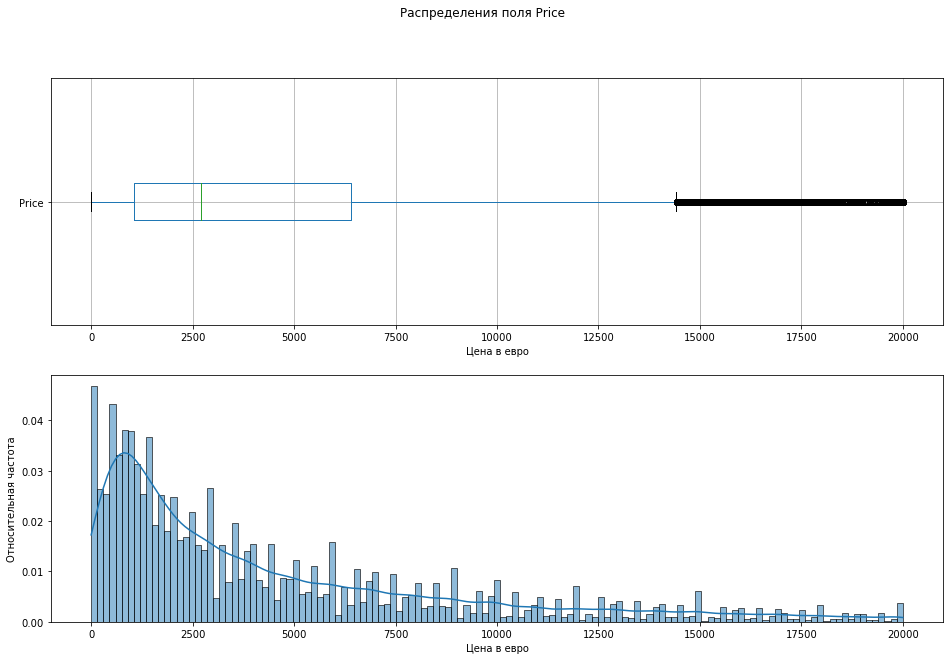

In [65]:
visualize()

#### Вывод

Поле имеет логнормальное распределение и не содержит выбросов. Однако машины с нулевой ценой вызывают подозрение, рассмотрим их отдельно.

### Обработка полей не влияющих на цену 

Предположим, что на цену не влияют следующие поля:
    
- DateCrawled
- RegistrationMonth
- DateCreated
- NumberOfPictures
- PostalCode
- LastSeen

Проверим наши предположения 

In [66]:
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

In [67]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','NotRepaired','DateCrawled','DateCreated', 'LastSeen']
tmp = data.drop(columns=columns)
tmp = tmp.drop(columns=['Price'])
X_train_fs, fs = select_features(tmp, data['Price'])

In [68]:
features = pd.DataFrame(fs.scores_, index=tmp.columns,columns=['scores'])

In [69]:
features.sort_values('scores',ascending=False)

,scores
Kilometer,44255.868120
FuelType_m,32201.801854
NotRepaired_m,32188.416730
Gearbox_m,25446.742027
Power,9175.891954
LastSeen_m,8094.046856
RegistrationMonth,4386.901434
Brand_m,3974.627340
VehicleType_m,2446.226977
PostalCode,2061.717183


В изначальном наборе данных количество картинок для вех машин равно 0, поэтому влияние этого признака на цену NULL. Поле Model не виляет на цену, так как  показывает тип машины (сидан, хешбек и т. д.). Не понятно почему LastSeen сильно влияет на цену, предположим что это ошибка. Удалим все поля до VehicleType, а также поле LastSeen

In [70]:
data.drop(columns=['PostalCode','Model','RegistrationYear','DateCrawled','DateCreated','NumberOfPictures','LastSeen'], inplace=True)

<div class="alert alert-block alert-success">
<b>Успех:</b> Согласен, что бОльшую часть этих колонок стоит удалить.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Кажется, что model – полезный признак. Возможно, имело смысл применить другой способ кодировки этой категориальной переменной.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Не понятно каким способом закодировать этот признак ? Если применить OneHotEncoder то как отбирать признаки ? Стоит ли перебирать способы кодирование при отборе признаков ? 
</div>


In [71]:
data.drop(columns=['Model_m','DateCrawled_m','DateCreated_m','LastSeen_m',
                  'VehicleType_m', 'Gearbox_m', 'FuelType_m', 'Brand_m','NotRepaired_m'], inplace=True)

In [72]:
data.head()

,Price,VehicleType,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,manual,0,150000,0,petrol,volkswagen,unknown
1,18300,coupe,manual,190,125000,5,gasoline,audi,yes
2,9800,suv,auto,163,125000,8,gasoline,jeep,unknown
3,1500,small,manual,75,150000,6,petrol,volkswagen,no
4,3600,small,manual,69,90000,7,gasoline,skoda,no


### Обработка полей влияющих на цену 

#### Поле Power

In [73]:
data['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

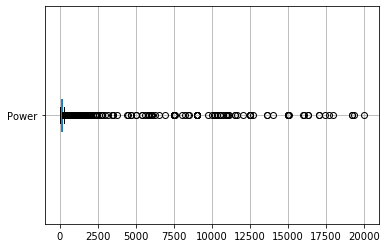

In [74]:
data.boxplot('Power',vert=False)

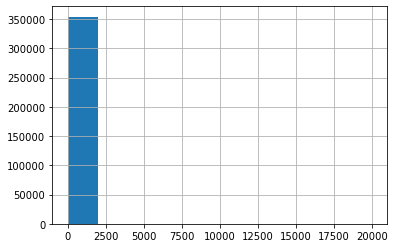

In [75]:
data['Power'].hist()

Признак имеет непонятное распределение. Скорее всего, нули стоят там где пользователь не знал что ставить. Просто масштабируем данный признак после разбиение данных на обучающую и тестовую выборки

#### Поле Kilometer

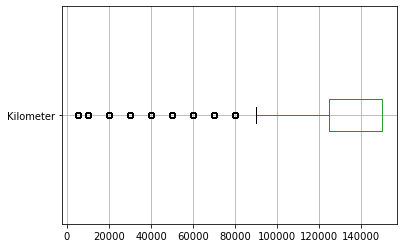

In [76]:
data.boxplot('Kilometer',vert=False)

Аномалий не обнаружено, просто масштабируем признак после разбиение данных на обучающую и тестовую выборки

#### Вывод

Данные готовы для обучения градиентного бустинга

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 9 columns):
Price                354369 non-null int64
VehicleType          354369 non-null object
Gearbox              354369 non-null object
Power                354369 non-null int64
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
dtypes: int64(4), object(5)
memory usage: 24.3+ MB


In [78]:
data.head()

,Price,VehicleType,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,manual,0,150000,0,petrol,volkswagen,unknown
1,18300,coupe,manual,190,125000,5,gasoline,audi,yes
2,9800,suv,auto,163,125000,8,gasoline,jeep,unknown
3,1500,small,manual,75,150000,6,petrol,volkswagen,no
4,3600,small,manual,69,90000,7,gasoline,skoda,no


## Обучение моделей

In [79]:
grid_report = pd.DataFrame(columns=['model', 'train_time', 'predict_time', 'rmse', 'rmse_on_test', 'params'])

In [80]:
def my_train_test_split(data):
    df_train, df_test = train_test_split(data, test_size=0.25, random_state=12345)
    
    df_train_x, df_train_y = split_x_y(df_train,'Price')
    df_test_x, df_test_y = split_x_y(df_test,'Price')
    
    return df_train_x, df_train_y, df_test_x, df_test_y

In [81]:
def my_GridSearchCV(mode, parametrs):
    
    grid = GridSearchCV(model(), parametrs, cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(train_x, train_y)
    
    mode = model(**grid.best_params_)
    
    start = time.time()
    mode.fit(train_x, train_y)
    end = time.time()
    
    train_time = end - start
    
    start = time.time()
    predicts = mode.predict(test_x)
    end = time.time()
    
    predict_time = end - start
    
    rmse_on_test = mean_squared_error(test_y, predicts) ** 0.5
    
    row = [model.__name__, train_time, predict_time, grid.best_score_ * -1, rmse_on_test, grid.best_params_]
    return pd.DataFrame([row], columns=['model', 'train_time', 'predict_time', 'rmse', 'rmse_on_test', 'params'])

<div class="alert alert-block alert-success">
<b>Успех:</b> Отличная функция. радует, что ты замеряешь именно время обучения, а не время подбора параметров.
</div>

In [82]:
train_x, train_y, test_x, test_y = my_train_test_split(data)

### Масштабирование признаков

In [83]:
scaler = MinMaxScaler()

In [84]:
train_x[['Power','Kilometer']] = scaler.fit_transform(train_x[['Power','Kilometer']])

In [85]:
train_x.head()

,VehicleType,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
25945,sedan,manual,0.00660,1.000000,4,petrol,ford,no
57619,sedan,manual,0.00000,1.000000,6,petrol,mercedes_benz,unknown
14516,small,manual,0.00375,1.000000,7,petrol,renault,no
283907,sedan,manual,0.00750,0.448276,10,gasoline,nissan,no
161548,wagon,manual,0.00550,0.379310,8,gasoline,opel,no


In [86]:
test_x[['Power','Kilometer']] = scaler.fit_transform(test_x[['Power','Kilometer']])

In [87]:
test_x.head()

,VehicleType,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
18734,bus,auto,0.007809,1.000000,4,gasoline,mercedes_benz,no
141787,other,manual,0.007445,0.241379,5,gasoline,bmw,no
37523,sedan,manual,0.006508,1.000000,12,petrol,opel,no
194192,sedan,auto,0.011662,1.000000,9,gasoline,mercedes_benz,no
110210,other,manual,0.003540,1.000000,9,gasoline,volkswagen,no


<div class="alert alert-block alert-info">
<b>Совет: </b> Все scaler-ы стоит применять после разделения выборки на части. При это обучение нужно проводить только на тренировочных данных, а применять нужно ко всем.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Переделал но не понятно почему так лучше ?
</div>

##  Обучение градиентного бустинга


###  Кодирование признаков 

In [88]:
train_x['RegistrationMonth'] = train_x['RegistrationMonth'].astype('category')

In [89]:
train_x[train_x.select_dtypes(['object']).columns] = train_x.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [90]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265776 entries, 25945 to 217570
Data columns (total 8 columns):
VehicleType          265776 non-null category
Gearbox              265776 non-null category
Power                265776 non-null float64
Kilometer            265776 non-null float64
RegistrationMonth    265776 non-null category
FuelType             265776 non-null category
Brand                265776 non-null category
NotRepaired          265776 non-null category
dtypes: category(6), float64(2)
memory usage: 7.6 MB


In [91]:
test_x['RegistrationMonth'] = test_x['RegistrationMonth'].astype('category')

In [92]:
test_x[test_x.select_dtypes(['object']).columns] = test_x.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [93]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88593 entries, 18734 to 55185
Data columns (total 8 columns):
VehicleType          88593 non-null category
Gearbox              88593 non-null category
Power                88593 non-null float64
Kilometer            88593 non-null float64
RegistrationMonth    88593 non-null category
FuelType             88593 non-null category
Brand                88593 non-null category
NotRepaired          88593 non-null category
dtypes: category(6), float64(2)
memory usage: 2.5 MB


###  Обучение модели

In [94]:
parametrs = {
    #'num_leaves': [7, 14, 21, 28, 31, 50],
    #'learning_rate': [0.1, 0.03, 0.003],
    #'max_depth': [-1, 3, 5],
    #'n_estimators': [50, 100, 200, 500],
    'random_state':[12345]
}

In [95]:
model = LGBMRegressor

In [96]:
result = my_GridSearchCV(model, parametrs)

LightGBMError: Check failed: (best_split_info.left_count) > (0) at /__w/1/s/python-package/compile/src/treelearner/serial_tree_learner.cpp, line 651 .


<div class="alert alert-block alert-info">
<b>Совет: </b> Можно попробовать еще немного увеличить learning_rate.
</div>

In [ ]:
grid_report = grid_report.append(result)

In [ ]:
grid_report

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> У моделей Catboost и lightGBM существуют внутренние механизмы обработки категориальных признаков. В данном случае нужно использовать их. Более подробную информацию можно найти в интернете.
    <br> Подскажу с lightGBM: достаточно изменить тип колонок с категориальными признаками на соответствующий: .astype('category').
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Сделанно. Не рабртает ;-(. Читал <a href="https://www.thekerneltrip.com/machine-learning/lgbmgpu/"> здесь </a> и <a href='https://github.com/microsoft/LightGBM/issues/3679'> здесь </a>. Ошибка в библиотеки, я быстрого решения не нашел. Только кодировать самому, как было до этого 
</div>

##  Обучение других моделей 

###  Кодирование признаков 

In [ ]:
Для остальных моделей данное кодирование не подходит. Перекодируем признаки в фиктивные переменные 

### Простой регрессор  

In [ ]:
parametrs = { 'strategy': ('mean', 'median') }

In [ ]:
model = DummyRegressor

In [ ]:
result = my_GridSearchCV(model, parametrs)

In [ ]:
grid_report = grid_report.append(result)

In [ ]:
grid_report

### Линейная регрессия 

In [ ]:
parametrs = {'fit_intercept': ('True', 'False'), 'normalize' :('False','True')}

In [ ]:
model = LinearRegression

In [ ]:
result = my_GridSearchCV(model, parametrs)

In [ ]:
grid_report = grid_report.append(result)

In [ ]:
grid_report

### Решающие дерево

In [ ]:
parametrs = {'max_depth' : range(10, 50, 20), 'random_state':[12345]}

In [ ]:
model = DecisionTreeRegressor

In [ ]:
result = my_GridSearchCV(model, parametrs)

In [ ]:
grid_report = grid_report.append(result)

In [ ]:
grid_report

<div class="alert alert-block alert-success">
<b>Успех:</b> В остальном, этот шаг был сделан восхитительно, так держать!
</div>

## Анализ моделей

In [ ]:
grid_report.reset_index(drop=True, inplace=True)

### Качество на обучающей выборки 

In [ ]:
grid_report.sort_values('rmse')

### Качество на тестовой  выборки 

In [ ]:
grid_report.sort_values('rmse_on_test')

### Время обучения 

In [ ]:
grid_report.sort_values('train_time')

### Время предсказания  

In [ ]:
grid_report.sort_values('predict_time')

## Заключение 

Как на тестовой выборки так и по кросс-валидация победил градиентный бустинг. Его ошибка на тестовой выборки составляет 2302.911603 евро, а  по кросс-валидация 2308.980276 евро, соответственно. Однако, эта модель учиться и предсказывает медленней всех (обучение 2.337584, предсказание 0.421447). Возможно, заказчик предпочтет более быструю модель решающего дерева (обучение 1.401853, предсказание 0.026315) при относительно небольшой потери качества (на тестовой выборки 2673.375616, по кросс-валидация 2667.058149 )

<div class="alert alert-block alert-success">
<b>Успех:</b> Сравнение моделей проведено хорошо.
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей